# Measuring a JND using aepsych

This tutorial builds an experiment to test your just-noticeable-difference (JND) to orientation.  

This experiment determines the smallest angular deviation that is needed for you to detect that a gabor stimulus isn’t vertical (or at some other reference orientation). The method presents a pair of stimuli at once with the observer having to report with a key press whether the left or the right stimulus was at the reference orientation (e.g. vertical).

It is modeled after [PsychpyPy's Tutorial 2](https://www.psychopy.org/coder/tutorial2.html), which measures a JND using a staircase procedure. We have made modifications to the original experiment by adding our adaptive sampling procedure.  



## Load appropriate packages

The first lines of code import the necessary libraries. We need lots of the PsychoPy modules for a full experiment, as well as numpy (which handles various numerical/mathematical functions).  We also need modules from our adaptive experimentation, aepsych.  

In [1]:
"""measure your JND in orientation using a staircase method"""
from psychopy import core, visual, gui, data, event
from psychopy.tools.filetools import fromFile, toFile
from scipy.stats import bernoulli, norm
from IPython.display import Image
import numpy, random
import torch
import matplotlib.pyplot as plt



from aepsych.strategy import (
    SequentialStrategy,
    SobolStrategy,
    ModelWrapperStrategy,
)
from aepsych.plotting import get_lse_contour
from aepsych.modelbridge.pairwise_probit import PairwiseProbitModelbridge
from aepsych.acquisition.monotonic_rejection import MonotonicMCLSE
from aepsych.plotting import make_debug_plots
from aepsych.psychopy_handler import BayesoptHandler



## Get info from the user

The `try:...except:...` lines allow us to try and load a parameter file from a previous run of the experiment. If that fails (e.g. because the experiment has never been run) then create a default set of parameters. These are easy to store in a python dictionary that we’ll call expInfo:

In [ ]:
try:  # try to get a previous parameters file
    expInfo = fromFile('lastParams.pickle')
except:  # if not there then use a default set
    expInfo = {'observer':'llwo', 'refOrientation':0}
expInfo['dateStr'] = data.getDateStr()  # add the current time

The last line adds the current date to to the information, whether we loaded from a previous run or created default values.

So having loaded those parameters, let’s allow the user to change them in a dialogue box (which we’ll call dlg). This is the simplest form of dialogue, created directly from the dictionary above. the dialogue will be presented immediately to the user and the script will wait until they hit OK or Cancel.

If they hit OK then `dlg.OK=True`, in which case we’ll use the updated values and save them straight to a parameters file (the one we try to load above).

If they hit Cancel then we’ll simply quit the script and not save the values.

In [ ]:
# present a dialogue to change params
dlg = gui.DlgFromDict(expInfo, title='simple JND Exp', fixed=['dateStr'])
if dlg.OK:
    toFile('lastParams.pickle', expInfo)  # save params to file for next time
else:
    core.quit()  # the user hit cancel so exit

## Setup the information for trials

We’ll create a file to which we can output some data as text during each trial (as well as outputting a binary file at the end of the experiment). PsychoPy actually has supporting functions to do this automatically, but here we’re showing you the manual way to do it.

We’ll create a filename from the `subject+date+".csv"` (note how easy it is to concatenate strings in python just by ‘adding’ them). csv files can be opened in most spreadsheet packages. Having opened a text file for writing, the last line shows how easy it is to send text to this target document.

In [ ]:
# make a text file to save data
fileName = expInfo['observer'] + expInfo['dateStr']
dataFile = open(fileName+'.csv', 'w')  # a simple text file with 'comma-separated-values'
dataFile.write('targetSide,oriIncrement,correct\n')

The window that appears with look like this:

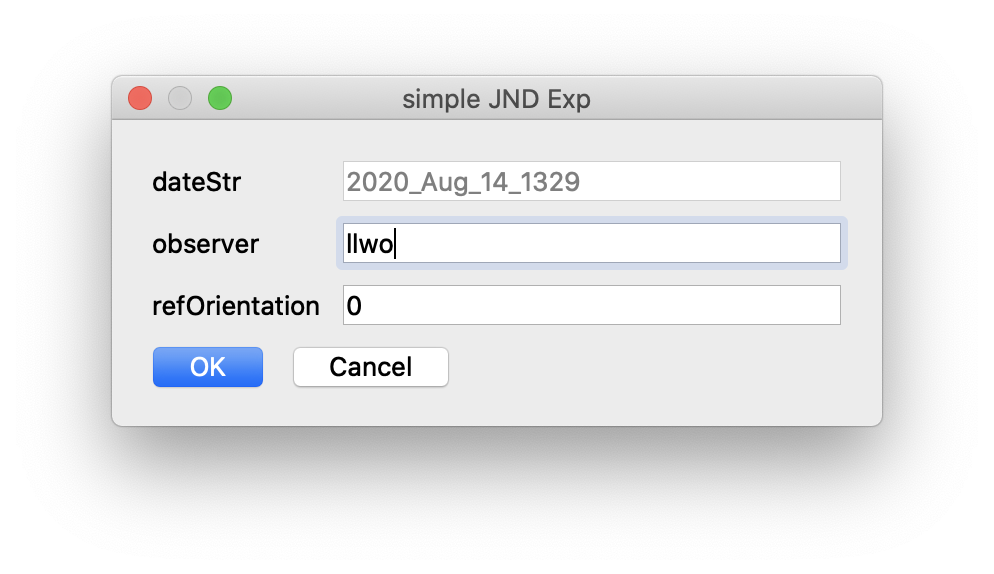

In [2]:
Image("JND_files/exp_input.png")

Next we need to set up our adaptive sampling strategy. Instead of using a staircase procedure, like PsychoPy's `StairHandler`, which begins with some specified and detectable value and incrementaly homes in on a threshold value, we will use a sample-efficient strategy for estimating the perceptual threshold. We need to specifiy a the number of initializing trials `n_init` and the number of optimization trials `n_opt` as well as lower bound `lb` and an upper bound `ub` as well as the `target` threshould (75%).  

In [ ]:
seed = 2
torch.manual_seed(seed)
np.random.seed(seed)
n_init = 5
n_opt = 15
lb = 0.0
ub = 20
target_thresh = .75

Then we need to set up a sequence of sampling strategies.  For this example we first initialize the model with 5 Sobol sampling trials, then 15 trials using our monotonic GP acquisition method.  

In [ ]:
objective = None
extra_acqf_args = {"beta": 1.96, "objective": objective, "target": target_thresh}
strat_list = [
    SobolStrategy(lb=lb, ub=ub, n_trials=n_init, seed=seed),
    ModelWrapperStrategy(
        modelbridge=MonotonicSingleProbitModelbridge(
            lb=lb,
            ub=ub,
            acqf=MonotonicMCLSE,
            extra_acqf_args=extra_acqf_args,
            monotonic_idxs=[0],
        ),
        n_trials=n_opt,
    ),
]

strat = SequentialStrategy(strat_list)

## Build your stimuli

Now we need to create a window, some stimuli and timers. We need a `psychopy.visual.Window` in which to draw our stimuli, a fixation point and two `psychopy.visual.GratingStim` stimuli (one for the target probe and one as the foil). We can have as many timers as we like and reset them at any time during the experiment, but I generally use one to measure the time since the experiment started and another that I reset at the beginning of each trial.

In [ ]:
# create window and stimuli
win = visual.Window([800,600],allowGUI=True,
                    monitor='testMonitor', units='deg')
foil = visual.GratingStim(win, sf=1, size=4, mask='gauss',
                          ori=expInfo['refOrientation'])
target = visual.GratingStim(win, sf=1, size=4, mask='gauss',
                            ori=expInfo['refOrientation'])
fixation = visual.GratingStim(win, color=-1, colorSpace='rgb',
                              tex=None, mask='circle', size=0.2)
# and some handy clocks to keep track of time
globalClock = core.Clock()
trialClock = core.Clock()

The window will look like this:

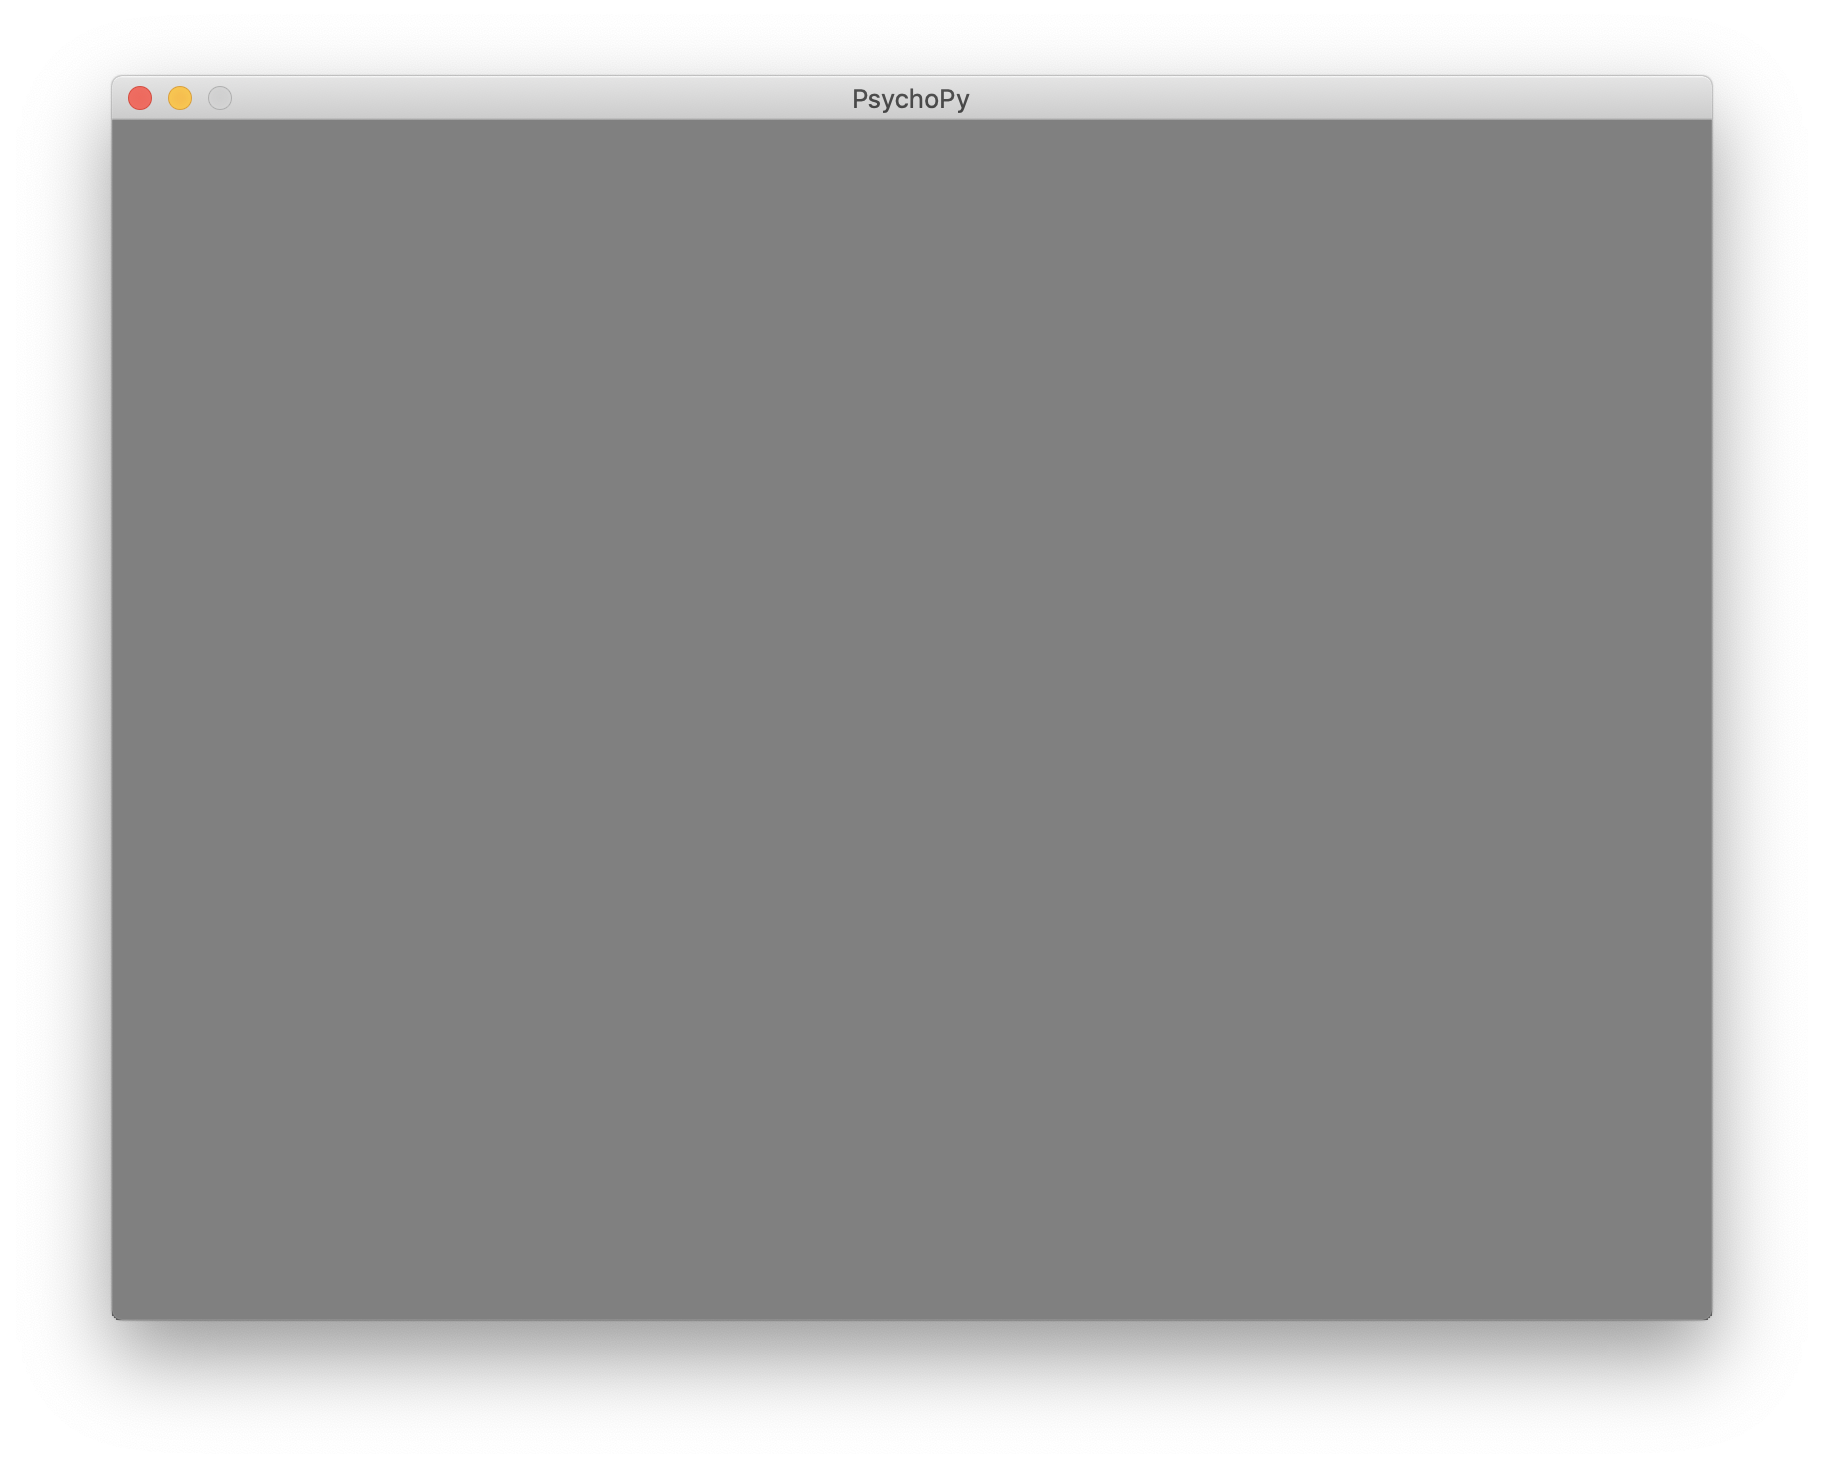

In [3]:
Image("JND_files/window.png")

Once the stimuli are created we should give the subject a message asking if they’re ready. The next two lines create a pair of messages, then draw them into the screen and then update the screen to show what we’ve drawn. Finally we issue the command event.waitKeys() which will wait for a keypress before continuing.

In [ ]:
# display instructions and wait
message1 = visual.TextStim(win, pos=[0,+3],text='Hit a key when ready.')
message2 = visual.TextStim(win, pos=[0,-3],
    text="Then press left or right to identify the %.1f deg probe." %expInfo['refOrientation'])
message1.draw()
message2.draw()
fixation.draw()
win.flip()#to show our newly drawn 'stimuli'
#pause until there's a keypress
event.waitKeys()

The instruction message will look like this:

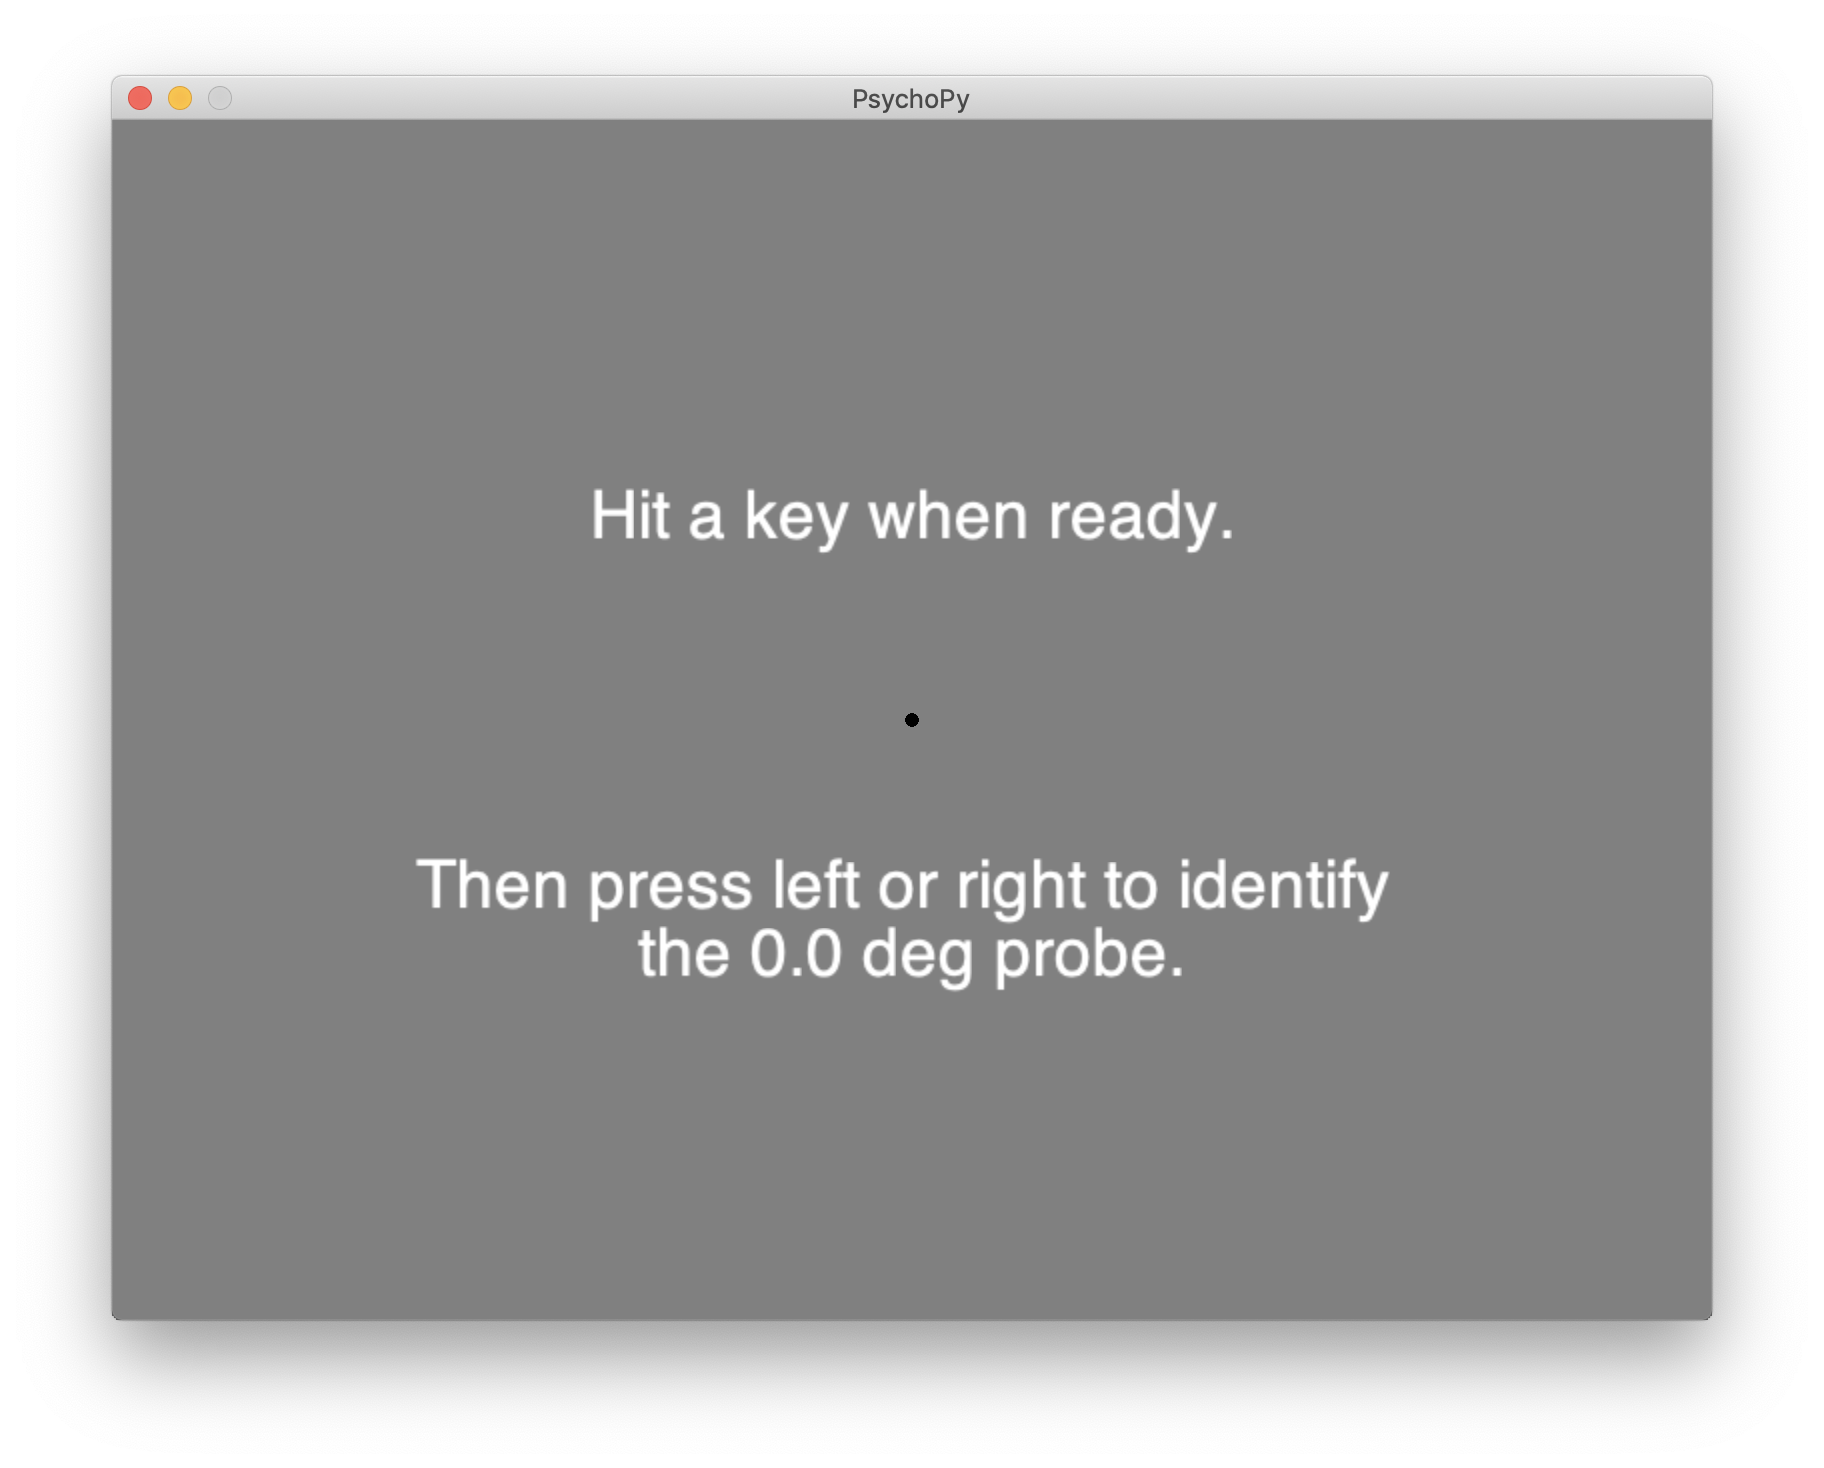

In [4]:
Image("JND_files/instructions.png")

## Control the presentation of the stimuli

OK, so we have everything that we need to run the experiment. The following uses a for-loop that will iterate over trials (`n_init + n_opt`) in the experiment. With each pass through the loop the staircase object will provide the new value for the intensity (which we will call `next_n`). We will randomly choose a side to present the target stimulus using `numpy.random.random()`, setting the position of the target to be there and the foil to be on the other side of the fixation point.

In [ ]:
for i in range(n_init + n_opt):  # will continue the staircase until it terminates!
    # set location of stimuli
    targetSide= random.choice([-1,1])  # will be either +1(right) or -1(left)
    foil.setPos([-5*targetSide, 0])
    target.setPos([5*targetSide, 0])  # in other location
    
    # provide value to next intensity
    thisN = strat.gen()
    print(thisN)

Then set the orientation of the foil to be the reference orientation plus `next_n`, draw all the stimuli (including the fixation point) and update the window.

In [ ]:
    # set orientation of probe
    foil.setOri(expInfo['refOrientation'] + thisN[0])

    # draw all stimuli
    foil.draw()
    target.draw()
    fixation.draw()
    win.flip()

The stimuli will look something like this:

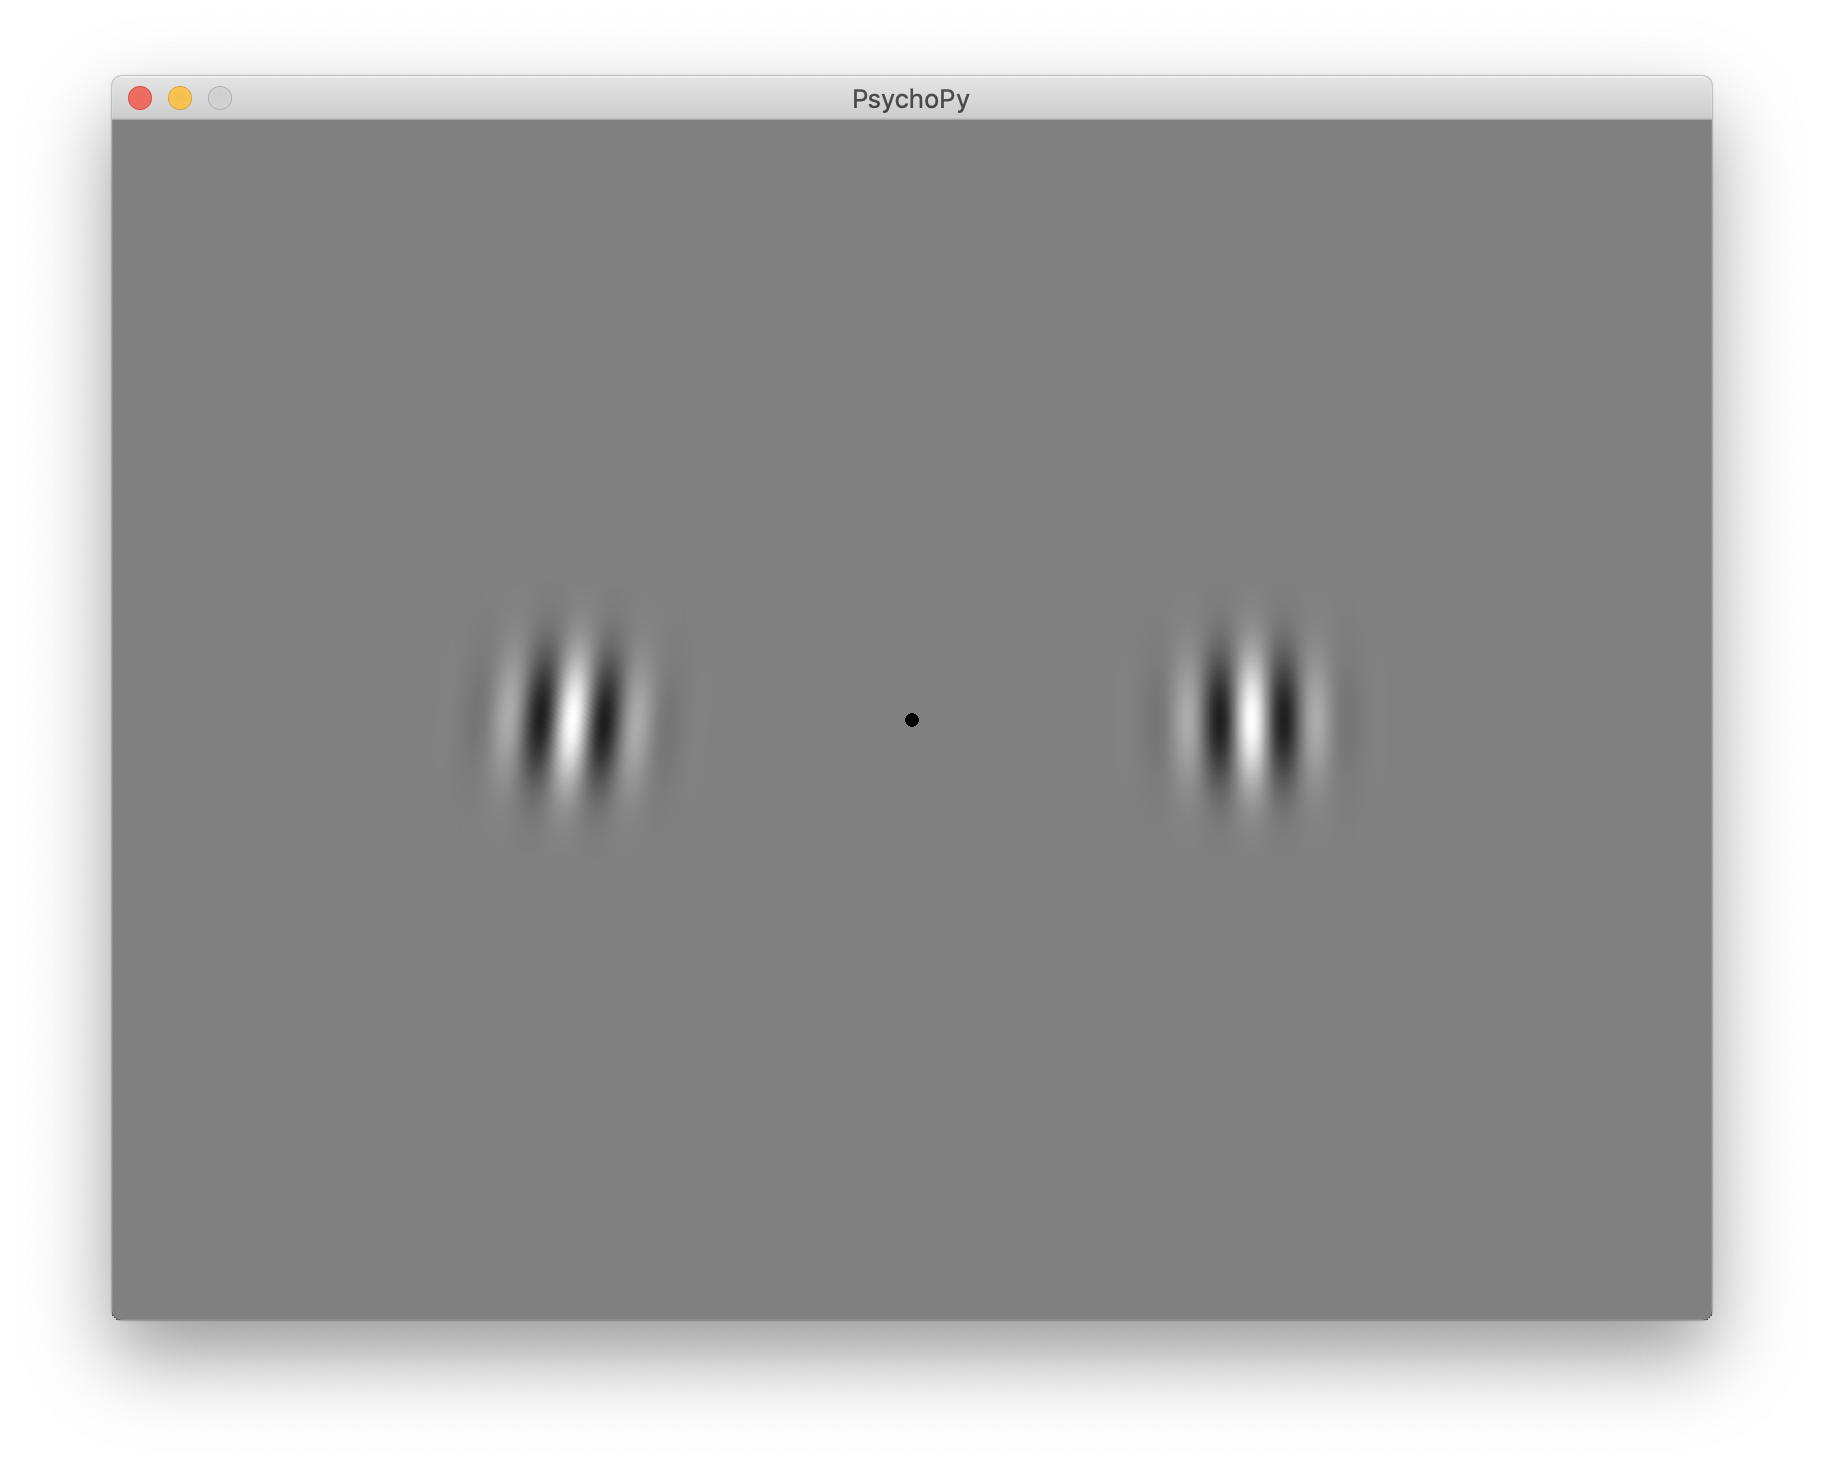

In [5]:
Image("JND_files/stimuli.png")

Wait for presentation time of 500ms and then blank the screen (by updating the screen after drawing just the fixation point).

In [ ]:
    # wait 500ms; but use a loop of x frames for more accurate timing
    core.wait(0.5)

(This is not the most precise way to time your stimuli - you’ll probably overshoot by one frame - but its easy to understand. PsychoPy allows you to present a stimulus for acertian number of screen refreshes instead which is better for short stimuli.)

## Get input from the subject

Still within the for-loop (note the level of indentation is the same) we need to get the response from the subject. The method works by starting off assuming that there hasn’t yet been a response and then waiting for a key press. For each key pressed we check if the answer was correct or incorrect and assign the response appropriately, which ends the trial. We always have to clear the event buffer if we’re checking for key presses like this

In [ ]:
    # blank screen
    fixation.draw()
    win.flip()

    # get response
    thisResp=None
    while thisResp==None:
        allKeys=event.waitKeys()
        for thisKey in allKeys:
            if thisKey=='left':
                if targetSide==-1: thisResp = 1  # correct
                else: thisResp = -1              # incorrect
            elif thisKey=='right':
                if targetSide== 1: thisResp = 1  # correct
                else: thisResp = -1              # incorrect
            elif thisKey in ['q', 'escape']:
                core.quit()  # abort experiment
        event.clearEvents()  # clear other (eg mouse) events - they clog the buffer

Now we must tell the model the result of this trial with its `strat.add_data()` method. Then it can work out whether the next trial is an increment or decrement. Also, on each trial (so still within the for-loop) we may as well save the data as a line of text in that .csv file we created earlier.

In [ ]:
    # add the data to the strategy so it can calculate the next level
    strat.add_data(thisN, [thisResp])
    dataFile.write('%i,%.3f,%i\n' %(targetSide, thisN, thisResp))
    core.wait(1)

## Output your data and clean up

Now, we’ve reached the end of the for-loop (which occurred because the `n_init + n_opt` terminated) which means the trials are over. The next step is to close the text data file and also save the results as a binary file (by ‘pickling’ the file in Python speak) which maintains a lot more info than we were saving in the text file.

In [ ]:
# trials have ended
dataFile.close()
## TO DO
### staircase.saveAsPickle(fileName)  # special python binary file to save all the info

While we’re here, it’s quite nice to give some immediate feedback to the user. Let’s tell them the intensity threshold value.

Having saved the data you can give your participant some feedback and quit!

In [ ]:
# give some output to user in the command line in the output window

xgrid = np.linspace(strat.lb, strat.ub, 100)
zhat, zvar = strat.modelbridge.predict(torch.Tensor(xgrid))
approxThreshold = get_lse_contour(zhat, xgrid, target_thresh)

print('approximated threshold = %.3f' % (approxThreshold))

# give some on-screen feedback
feedback1 = visual.TextStim(
        win, pos=[0,+3],
        text='approximated threshold = %.3f' % (approxThreshold))

feedback1.draw()
fixation.draw()
win.flip()
event.waitKeys()  # wait for participant to respond

win.close()
core.quit()

Feedback will look something like this:

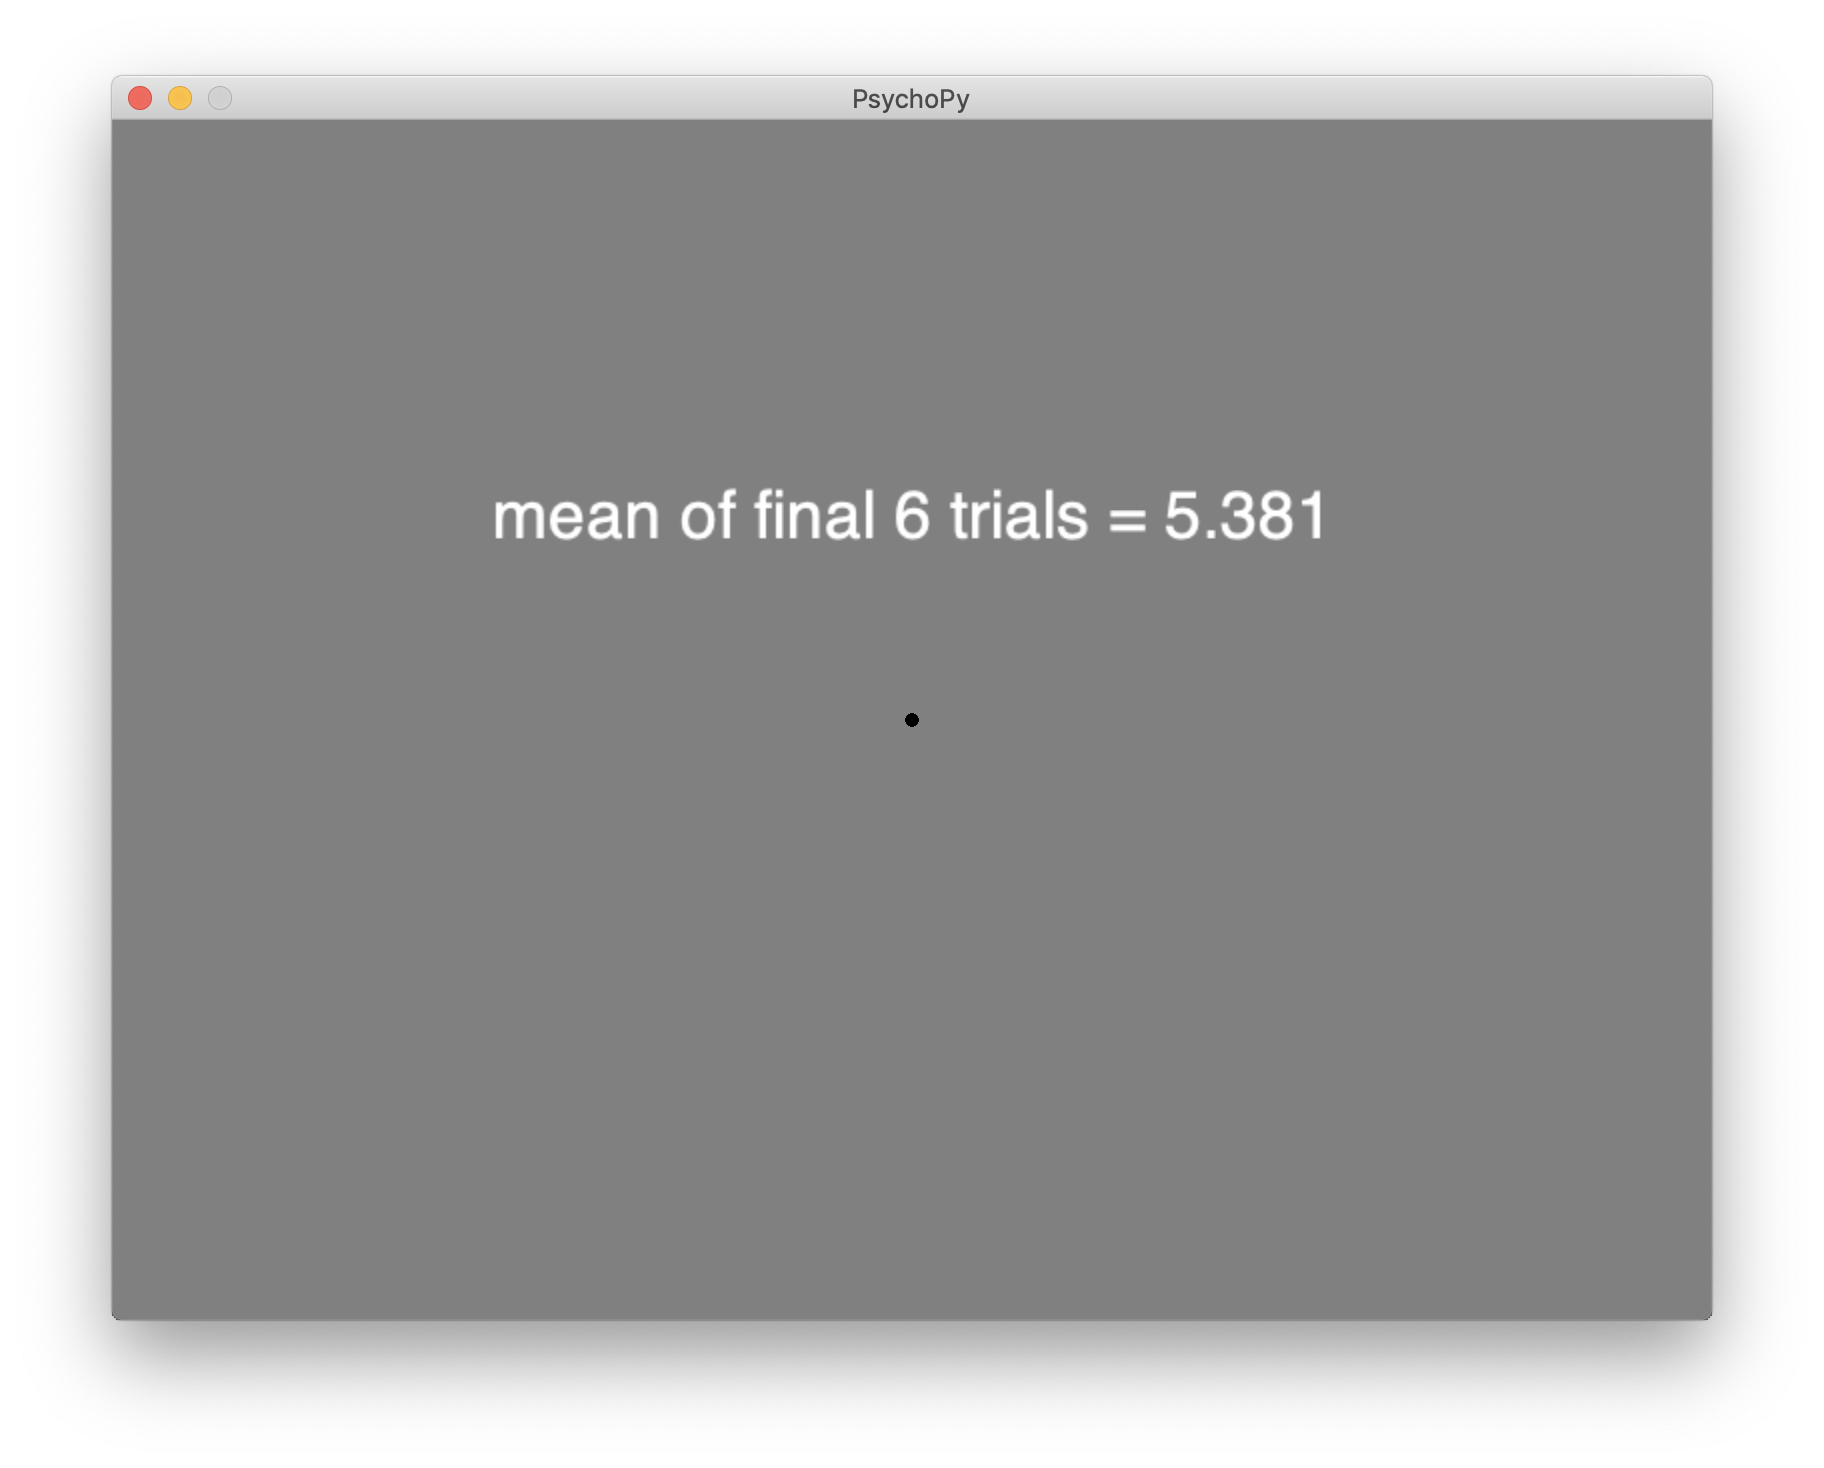

In [6]:
Image("JND_files/feedback.png")

Here's everything together! 

In [2]:
"""measure your JND in orientation using a staircase method"""
from psychopy import core, visual, gui, data, event
from psychopy.tools.filetools import fromFile, toFile
from scipy.stats import bernoulli, norm
import numpy, random
import torch
import matplotlib.pyplot as plt

from aepsych.strategy import (
    SequentialStrategy,
    SobolStrategy,
    ModelWrapperStrategy,
)
from aepsych.plotting import get_lse_contour
from aepsych.modelbridge.monotonic import MonotonicSingleProbitModelbridge
from aepsych.acquisition.monotonic_rejection import MonotonicMCLSE
from aepsych.plotting import make_debug_plots

try:  # try to get a previous parameters file
    expInfo = fromFile('lastParams.pickle')
except:  # if not there then use a default set
    expInfo = {'observer': 'llwo', 'refOrientation': 0}
expInfo['dateStr'] = data.getDateStr()  # add the current time

# present a dialogue to change params
dlg = gui.DlgFromDict(expInfo, title='simple JND Exp', fixed=['dateStr'])
if dlg.OK:
    toFile('lastParams.pickle', expInfo)  # save params to file for next time
else:
    core.quit()  # the user hit cancel so exit

# make a text file to save data
fileName = expInfo['observer'] + expInfo['dateStr']
dataFile = open(fileName + '.csv', 'w')  # a simple text file with 'comma-separated-values'
dataFile.write('targetSide,oriIncrement,correct\n')

seed = 2
torch.manual_seed(seed)
numpy.random.seed(seed)
n_init = 5
n_opt = 10
lb = 0.0
ub = 20
target_thresh = .75

objective = None
extra_acqf_args = {"beta": 1.96, "objective": objective, "target": target_thresh}
strat_list = [
    SobolStrategy(lb=lb, ub=ub, n_trials=n_init, seed=seed),
    ModelWrapperStrategy(
        modelbridge=MonotonicSingleProbitModelbridge(
            lb=lb,
            ub=ub,
            acqf=MonotonicMCLSE,
            extra_acqf_args=extra_acqf_args,
            monotonic_idxs=[0],
        ),
        n_trials=n_opt,
    ),
]

strat = SequentialStrategy(strat_list)

# create window and stimuli
win = visual.Window([800, 600], allowGUI=True,
                    monitor='testMonitor', units='deg')
foil = visual.GratingStim(win, sf=1, size=4, mask='gauss',
                          ori=expInfo['refOrientation'])
target = visual.GratingStim(win, sf=1, size=4, mask='gauss',
                            ori=expInfo['refOrientation'])
fixation = visual.GratingStim(win, color=-1, colorSpace='rgb',
                              tex=None, mask='circle', size=0.2)

# display instructions and wait
message1 = visual.TextStim(win, pos=[0,+3],text='Hit a key when ready.')
message2 = visual.TextStim(win, pos=[0,-3],
    text="Then press left or right to identify the %.1f deg probe." %expInfo['refOrientation'])
message1.draw()
message2.draw()
fixation.draw()
win.flip()#to show our newly drawn 'stimuli'
#pause until there's a keypress
event.waitKeys()

# and some handy clocks to keep track of time
globalClock = core.Clock()
trialClock = core.Clock()

for i in range(n_init + n_opt):  # will continue the staircase until it terminates!
    # set location of stimuli
    targetSide = random.choice([-1, 1])  # will be either +1(right) or -1(left)
    foil.setPos([-5 * targetSide, 0])
    target.setPos([5 * targetSide, 0])  # in other location

    # provide value to next intensity
    thisN = strat.gen()
    print(thisN)

    # set orientation of probe
    foil.setOri(expInfo['refOrientation'] + thisN[0])

    # draw all stimuli
    foil.draw()
    target.draw()
    fixation.draw()
    win.flip()
    # wait 500ms; but use a loop of x frames for more accurate timing
    core.wait(0.5)

    # blank screen
    fixation.draw()
    win.flip()

    # get response
    thisResp = None
    while thisResp == None:
        allKeys = event.waitKeys()
        for thisKey in allKeys:
            if thisKey == 'left':
                if targetSide == -1:
                    thisResp = 1  # correct
                else:
                    thisResp = -1  # incorrect
            elif thisKey == 'right':
                if targetSide == 1:
                    thisResp = 1  # correct
                else:
                    thisResp = -1  # incorrect
            elif thisKey in ['q', 'escape']:
                core.quit()  # abort experiment
        event.clearEvents()  # clear other (eg mouse) events - they clog the buffer

    # add the data to the strategy so it can calculate the next level
    strat.add_data(thisN, [thisResp])
    dataFile.write('%i,%.3f,%i\n' % (targetSide, thisN, thisResp))
    core.wait(1)

# trials have ended
dataFile.close()
## TO DO
### staircase.saveAsPickle(fileName)  # special python binary file to save all the info
# give some output to user in the command line in the output window

xgrid = np.linspace(strat.lb, strat.ub, 100)
zhat, zvar = strat.modelbridge.predict(torch.Tensor(xgrid))
approxThreshold = get_lse_contour(zhat, xgrid, target_thresh)

# print('approximated threshold = %.3f' % (approxThreshold))

# give some on-screen feedback
feedback1 = visual.TextStim(
        win, pos=[0,+3],
        text='approximated threshold = %.3f' % (approxThreshold))

feedback1.draw()
fixation.draw()
win.flip()
event.waitKeys()  # wait for participant to respond

win.close()
core.quit()

[5.18429399]
[2.48425364]
[12.0777607]
[14.47991133]
[4.68865842]
[0.8671755]
[4.056612]
[3.3407626]
[4.712826]
[4.376296]
[3.7906356]


SystemExit: 0

/Users/lucyowen/anaconda3/envs/bayesopt_new/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3425: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
